This is a notebook intended to show case the What-If-Tool for insurance use case.

This is the model building part.

For any questions please reach out to crownpku@gmail.com

In [17]:
#install missing packages
!pip install shap
#!pip install matplotlib #--quiet
#!pip install xgboost==0.90 #--quiet 
#!pip install witwidget #--quiet
#!jupyter labextension install wit-widget
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager

     |████████████████████████████████| 327kB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 4.9MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 3.0MB/s eta 0:00:01     |███████████▋                    | 747kB 3.0MB/s eta 0:00:01
     |████████████████████████████████| 24.6MB 2.8MB/s eta 0:00:01     |██████████████████████████▌     | 20.4MB 2.8MB/s eta 0:00:02
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=501169 sha256=96aab92b18818ac88bd013b1cca5659096a885813427d94148ff461b871671e6
  Stored in directory: /home/crown/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for numba: filename=numba-0.51.2-cp36-cp36m-linux_x86_64.whl size=2941592 sha256=fc637dc63362b05de536aa1f91324e77476dfa5061bb394d980f37f118a4611c
  Stored in directory: /home/crown/.cache/pip/wheels/cd/cd/8c/314cbe49cd8bb876f251763442807db9d55968d1f44cb20013
Successfully built shap numba


In [1]:
import os
import warnings
import pandas as pd
import xgboost as xgb
import numpy as np
import collections
import witwidget

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder
import custom_transforms
%matplotlib inline
warnings.filterwarnings('ignore')

# Read and pre-process the data

In [2]:
df = pd.read_csv("../data/insurance.csv")
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'charges'}>,
        <AxesSubplot:title={'center':'children'}>]], dtype=object)

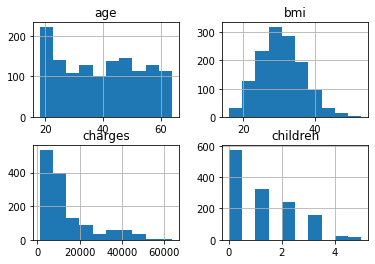

In [3]:
#Let's first look at the distribution of charges
df.hist()

# We plan to build 3 models:
1. Two simple models for Predictive Underwriting, so we convert medical charges to good/bad risks and train a binary classification model

    1.1 A decision tree model
    
    1.2 A logistic regression model
    
2. A simple model for Dynamic Pricing, so we treat it as a regression model.


## First Model: Predictive Underwriting

In [4]:
# Deep copy of the data for puW
df_puw = df.copy()

#Now let's put everyone whose charge is above 10000 as "Bad Risk" or as 0, else are "Good Risk" or as 1
def good_risk(row):
    if row['charges'] > 10000:
        return False
    else:
        return True
    
df_puw['risk'] = df.apply(good_risk, axis=1)
df_puw.drop(['charges'],axis=1, inplace=True)
df_puw.head()

,age,sex,bmi,children,smoker,region,risk
0,19,female,27.900,0,yes,southwest,False
1,18,male,33.770,1,no,southeast,True
2,28,male,33.000,3,no,southeast,True
3,33,male,22.705,0,no,northwest,False
4,32,male,28.880,0,no,northwest,True


In [5]:
#Now we build a logistic regression and a xgboost model to predict the risk
# Label preprocessing
labels = df_puw['risk'].values
data = df_puw.drop(columns=['risk'])

# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [6]:
numerical_indices = [0, 2, 3]  
categorical_indices = [1, 4, 5]  

p1 = make_pipeline(
    custom_transforms.PositionalSelector(categorical_indices),
    custom_transforms.StripString(),
    custom_transforms.SimpleOneHotEncoder()
)
p2 = make_pipeline(
    custom_transforms.PositionalSelector(numerical_indices),
    StandardScaler()
)
p3 = FeatureUnion([
    ('numericals', p1),
    ('categoricals', p2),
])

In [7]:

pipeline_decision_tree = make_pipeline(
    p3,
    DecisionTreeClassifier()
)

pipeline_logistic_regression = make_pipeline(
    p3,
    LogisticRegression()
)

pipeline_xgboost = make_pipeline(
    p3,
    xgb.sklearn.XGBClassifier()
)


In [8]:
# Train the model, this will take a few minutes to run
pipeline_decision_tree.fit(x_train, y_train)
pipeline_logistic_regression.fit(x_train, y_train)
pipeline_xgboost.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numericals',
                                                 Pipeline(memory=None,
                                                          steps=[('positionalselector',
                                                                  PositionalSelector(positions=[1,
                                                                                                4,
                                                                                                5])),
                                                                 ('stripstring',
                                                                  StripString()),
                                                                 ('simpleonehotencoder',
                                                                  SimpleOneHotEncoder())],
                                     

In [14]:
#decision tree
# Get predictions on the test set and print the accuracy score
y_pred = pipeline_decision_tree.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print('\n','Accuracy of Decision Tree is', acc, '\n')
# Print a confusion matrix
print('Confusion matrix for Decision Tree:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

#Logistic Regression
# Get predictions on the test set and print the accuracy score
y_pred = pipeline_logistic_regression.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print('\n\n','Accuracy of Logistic Regression is', acc, '\n')
# Print a confusion matrix
print('Confusion matrix for Logistic Regression:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)

#xgboost
# Get predictions on the test set and print the accuracy score
y_pred = pipeline_xgboost.predict(x_test)
acc = accuracy_score(y_test, y_pred.round())
print('\n\n','Accuracy of XGBoost is', acc, '\n')
# Print a confusion matrix
print('Confusion matrix for Logistic Regression:')
cm = confusion_matrix(y_test, y_pred.round())
cm = cm / cm.astype(np.float).sum(axis=1)
print(cm)


 Accuracy of Decision Tree is 0.8686567164179104 

Confusion matrix for Decision Tree:
[[0.84666667 0.12432432]
 [0.14       0.88648649]]


 Accuracy of Logistic Regression is 0.9044776119402985 

Confusion matrix for Logistic Regression:
[[0.89333333 0.08648649]
 [0.10666667 0.91351351]]


 Accuracy of XGBoost is 0.9313432835820895 

Confusion matrix for Logistic Regression:
[[0.86       0.11351351]
 [0.01333333 0.98918919]]


In [15]:
#Prepare data for what-if-tool
test_examples = x_test
test_examples['risk'] = y_test

In [16]:
#definea a customized prediction function so it fits the what-if-tool format
def customized_prediction_decision_tree(x):
    x_df = pd.DataFrame(x, columns=data.columns.tolist())
    return pipeline_decision_tree.predict_proba(x_df)

def customized_prediction_logistic_regression(x):
    x_df = pd.DataFrame(x, columns=data.columns.tolist())
    return pipeline_logistic_regression.predict_proba(x_df)

def customized_prediction_xgboost(x):
    x_df = pd.DataFrame(x, columns=data.columns.tolist())
    return pipeline_xgboost.predict_proba(x_df)

#fire up the tool
config_builder = (
    WitConfigBuilder(test_examples.values.tolist(), test_examples.columns.tolist())
    .set_custom_predict_fn(customized_prediction_logistic_regression)
    .set_compare_custom_predict_fn(customized_prediction_xgboost)
    .set_target_feature('risk')
    .set_model_type('classification')
    .set_label_vocab(['Bad Risk', 'Good Risk'])
)

WitWidget(config_builder, height=1000)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Bad Risk', 'Good Risk'], 'feature_names': […

### Quick comments:


## Second Model: Dynamic Pricing

In [39]:
# Deep copy of the data for dp
df_dp = df.copy()
df_dp.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [41]:
#Now we build a xgboost model to predict the risk
# Label preprocessing
labels = df_dp['charges'].values
data = df_dp.drop(columns=['charges'])

# Split the data into train / test sets
x,y = data,labels
x_train,x_test,y_train,y_test = train_test_split(x,y)

In [42]:
pipeline2 = make_pipeline(
    p3,
    xgb.sklearn.XGBRegressor()
)

In [43]:
# Train the model, this will take a few minutes to run
pipeline2.fit(x_train, y_train)

[16:23:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numericals',
                                                 Pipeline(memory=None,
                                                          steps=[('positionalselector',
                                                                  PositionalSelector(positions=[1,
                                                                                                4,
                                                                                                5])),
                                                                 ('stripstring',
                                                                  StripString()),
                                                                 ('simpleonehotencoder',
                                                                  SimpleOneHotEncoder())],
                                     

In [48]:
#Prepare data for what-if-tool
test_examples = x_test
test_examples['charges'] = y_test

In [50]:
#definea a customized prediction function so it fits the what-if-tool format
def customized_prediction2(x):
    x_df = pd.DataFrame(x, columns=data.columns.tolist())
    return pipeline2.predict(x_df)

#fire up the tool
config_builder = (
    WitConfigBuilder(test_examples.values.tolist(), test_examples.columns.tolist())
    .set_custom_predict_fn(customized_prediction2)
    .set_target_feature('charges')
    .set_model_type('regression')
)

WitWidget(config_builder, height=800)

WitWidget(config={'model_type': 'regression', 'label_vocab': [], 'feature_names': ['age', 'sex', 'bmi', 'child…

### Quick comments: